In [1]:
import pandas as pd

DATA_PATH = "../../data/processed/zone_hour_clusters.parquet"

df = pd.read_parquet(DATA_PATH)
df.head()

,zone_id,pickup_hour_ts,demand,avg_fare,avg_distance,hour,day_of_week,is_weekend,day,month,cluster
0,1,2019-01-01 10:00:00,2,61.25,16.90,10,1,0,1,1,3
1,1,2019-01-01 12:00:00,1,135.00,19.30,12,1,0,1,1,3
2,1,2019-01-01 15:00:00,1,106.00,41.28,15,1,0,1,1,3
3,1,2019-01-02 02:00:00,1,30.00,1.27,2,2,0,2,1,1
4,1,2019-01-02 03:00:00,1,15.00,12.65,3,2,0,2,1,1


### Cluster sizes

In [2]:
cluster_sizes = df["cluster"].value_counts().sort_index()
cluster_sizes

cluster
0     30027
1    151352
2     74219
3     41209
Name: count, dtype: int64

This shows how many zone–hour observations belong to each cluster.

### Compute cluster profiles

In [3]:
cluster_profile = (
    df
    .groupby("cluster")
    .agg(
        demand_mean=("demand", "mean"),
        demand_std=("demand", "std"),
        avg_fare_mean=("avg_fare", "mean"),
        avg_distance_mean=("avg_distance", "mean"),
        hour_mean=("hour", "mean"),
        weekend_share=("is_weekend", "mean")
    )
    .round(2)
)

cluster_profile

,demand_mean,demand_std,avg_fare_mean,avg_distance_mean,hour_mean,weekend_share
cluster,,,,,,
0,409.41,167.98,11.43,2.40,15.36,0.11
1,31.76,52.24,14.52,3.58,11.18,0.00
2,56.02,91.01,14.72,3.71,11.38,1.00
3,15.65,66.18,48.16,14.24,11.92,0.17


### Relative comparison

In [4]:
global_means = df[["demand", "avg_fare", "avg_distance"]].mean()
global_means

demand          73.795578
avg_fare        18.929249
avg_distance     4.973577
dtype: float64

In [5]:
relative_profile = cluster_profile.copy()

relative_profile["demand_vs_global"] = (
    cluster_profile["demand_mean"] / global_means["demand"]
)

relative_profile["fare_vs_global"] = (
    cluster_profile["avg_fare_mean"] / global_means["avg_fare"]
)

relative_profile["distance_vs_global"] = (
    cluster_profile["avg_distance_mean"] / global_means["avg_distance"]
)

relative_profile[[
    "demand_vs_global",
    "fare_vs_global",
    "distance_vs_global"
]].round(2)

,demand_vs_global,fare_vs_global,distance_vs_global
cluster,,,
0,5.55,0.60,0.48
1,0.43,0.77,0.72
2,0.76,0.78,0.75
3,0.21,2.54,2.86


### Temporal behavior per cluster - hour distribution

In [6]:
hour_profile = (
    df
    .groupby(["cluster", "hour"])
    .size()
    .reset_index(name="count")
)

hour_profile.head()

,cluster,hour,count
0,0,0,278
1,0,1,127
2,0,2,76
3,0,3,63
4,0,4,5


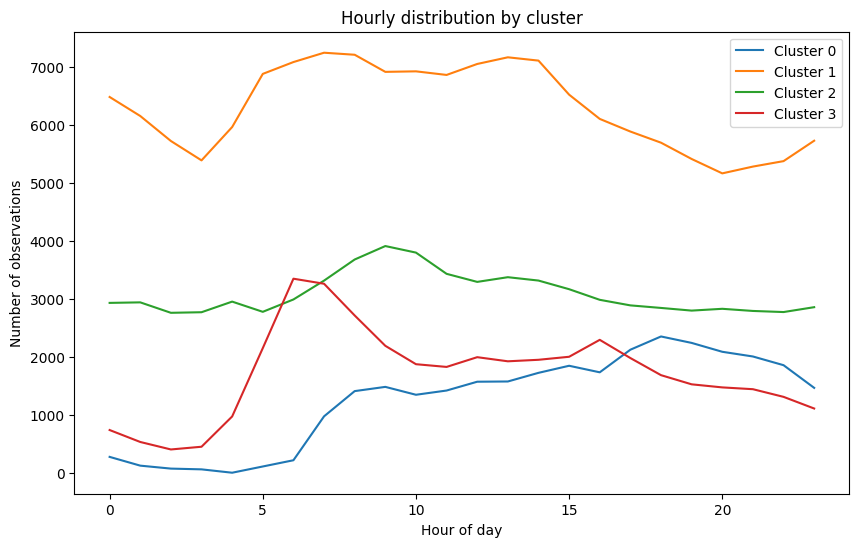

In [7]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,6))

for c in sorted(df["cluster"].unique()):
    subset = hour_profile[hour_profile["cluster"] == c]
    plt.plot(subset["hour"], subset["count"], label=f"Cluster {c}")

plt.xlabel("Hour of day")
plt.ylabel("Number of observations")
plt.title("Hourly distribution by cluster")
plt.legend()
plt.show()

### Weekend vs Weekday
Show the share of weekend observations per cluster.

In [9]:
df.groupby("cluster")["is_weekend"].mean()

cluster
0    0.108536
1    0.000000
2    1.000000
3    0.173433
Name: is_weekend, dtype: float64

### Add cluster names

In [12]:
cluster_names = {
    0: "Low-demand residential / off-peak",
    1: "High-demand central / peak-hour",
    2: "Medium-demand mixed-use",
    3: "Long-distance / higher fare demand"
}

In [13]:
df["cluster_label"] = df["cluster"].map(cluster_names)

df[["cluster", "cluster_label"]].drop_duplicates().sort_values("cluster")

,cluster,cluster_label
10041,0,Low-demand residential / off-peak
3,1,High-demand central / peak-hour
17,2,Medium-demand mixed-use
0,3,Long-distance / higher fare demand


## Interpretation of demand behavior clusters

Based on demand intensity, trip characteristics and temporal patterns,
four distinct demand behavior segments were identified.

The clusters represent recurring zone–hour demand profiles rather than
fixed spatial regions.

---

### Cluster 0 – Low-demand off-peak activity

This cluster is characterized by:

- clearly lower than average demand
- occurring predominantly during off-peak hours (late night and early morning)
- relatively short trips and lower average fares
- a low to moderate share of weekend observations

This segment likely represents low-intensity residential or peripheral
areas and time periods with limited taxi activity.

Operationally, this cluster corresponds to background demand rather than
commercially critical peak demand.

---

### Cluster 1 – High-demand peak-hour activity

This cluster is characterized by:

- significantly higher than average demand
- strong concentration during typical peak hours
- average to slightly higher fares
- mostly weekday observations

This segment represents peak commuting and central activity periods.
It captures the core high-volume demand regime of the city.

This cluster is particularly important for short-term demand forecasting
and operational planning because it concentrates a large share of total
rides.

---

### Cluster 2 – Medium-demand mixed-use activity

This cluster is characterized by:

- moderate demand levels close to the global average
- occurring across a wide range of hours
- average fares and trip distances

This segment likely represents mixed-use zones and time periods where
neither strong commuting nor strong leisure patterns dominate.

It can be interpreted as a transitional demand regime between peak and
off-peak behavior.

---

### Cluster 3 – Lower-frequency but long-distance / high-value demand

This cluster is characterized by:

- lower to medium demand volume
- noticeably higher average trip distance and fare
- weaker concentration around peak hours
- a relatively higher share of weekend observations

This segment likely corresponds to airport-related trips, long-distance
rides and leisure or special-purpose travel.

Although demand volume is lower, this cluster is economically important
due to higher trip value.

---

Overall, the four clusters capture distinct demand regimes:
off-peak background demand, high-intensity peak demand, mixed regular
activity, and long-distance or high-value trips.

## Methodological note

Clusters were learned on standardized numerical features and represent recurring zone–hour demand behavior patterns.

The cluster labels do not represent spatial regions but temporal demand profiles that can occur in multiple taxi zones.